In [1]:
# Import key Library
import sys
if 'gensim.downloader' not in sys.modules:
  try:
    import gensim.downloader as api
  except:
    !pip install gensim
    import gensim.downloader as api
  finally:
    glove_wiki = api.load("glove-wiki-gigaword-50")
    glove_twitter = api.load("glove-twitter-50")

else:
  print('gensim Already imported')
  glove_wiki = api.load("glove-wiki-gigaword-50")
  glove_twitter = api.load("glove-twitter-50")

import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.2 MB/s eta 0:00:00
[==================================================] 100.0% 66.0/66.0MB downloaded
[==================================================] 100.0% 199.5/199.5MB downloaded


In [2]:
# Print the shape of vectors (no.of words x dimensions) for each WikiPedia and Twitter embeddings
print(f"{'No. of words in Wikipedia model':40} : {glove_wiki.vectors.shape[0]:,}")
print(f"{'No. of words in Twitter model':40} : {glove_twitter.vectors.shape[0]:,}")

No. of words in Wikipedia model          : 400,000
No. of words in Twitter model            : 1,193,514


# Compare between two embeddings for a target word

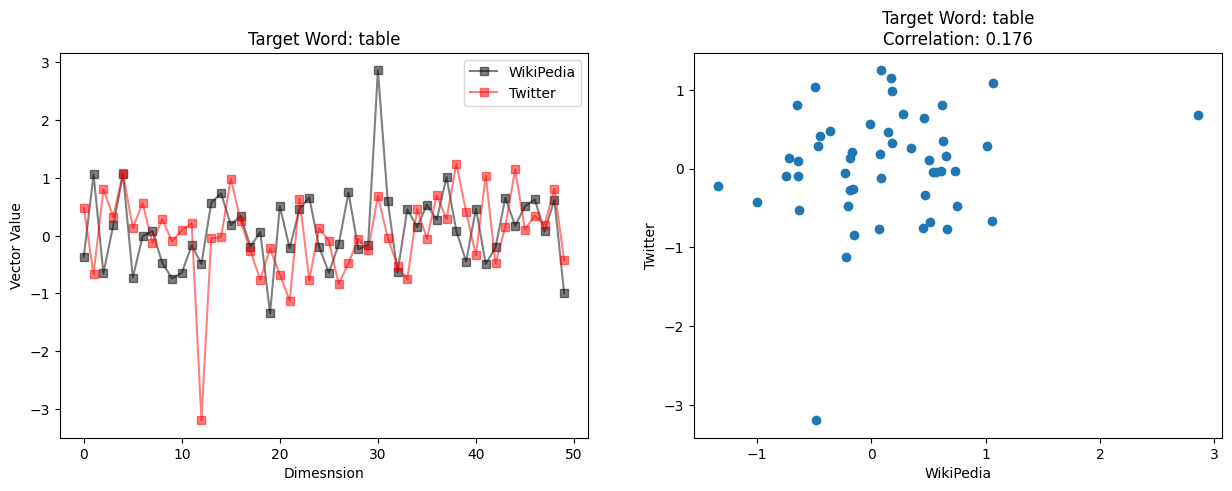

In [3]:
target_word = 'table'
glove_wiki_vector = glove_wiki.get_vector(target_word)
glove_twitter_vector = glove_twitter.get_vector(target_word)

corr = np.corrcoef(glove_wiki_vector, glove_twitter_vector)[0,1]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(glove_wiki_vector,'ks-',label='WikiPedia',alpha=0.5)
axs[0].plot(glove_twitter_vector, 'rs-', label='Twitter', alpha=0.5)
axs[0].set_xlabel('Dimesnsion')
axs[0].set_ylabel('Vector Value')
axs[0].legend()
axs[0].set_title('Target Word: '+target_word)

axs[1].scatter(glove_wiki_vector, glove_twitter_vector)
axs[1].set_xlabel('WikiPedia')
axs[1].set_ylabel('Twitter')
axs[1].set_title('Target Word: '+target_word + '\nCorrelation: '+str(round(corr,3)))

plt.show()

# Embeddings for a pair of words in the same model

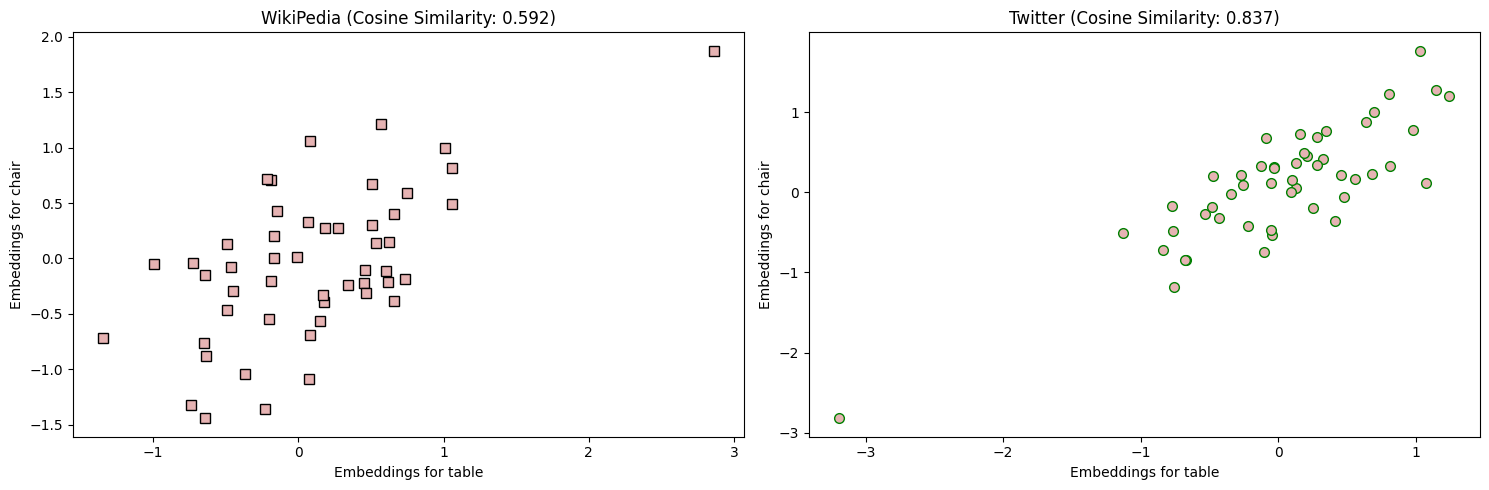

In [4]:
word1 = 'table'
word2 = 'chair'

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(glove_wiki[word1], glove_wiki[word2], 'ks', markersize=7,markerfacecolor=[.9,.7,.7])
axs[0].set(xlabel=f'Embeddings for {word1}', ylabel=f'Embeddings for {word2}')
axs[0].set_title(f'WikiPedia (Cosine Similarity: {glove_wiki.similarity(word1, word2):.3f})')

axs[1].plot(glove_twitter[word1], glove_twitter[word2], 'go', markersize=7,markerfacecolor=[.9,.7,.7])
axs[1].set(xlabel=f'Embeddings for {word1}', ylabel=f'Embeddings for {word2}')
axs[1].set_title(f'Twitter (Cosine Similarity: {glove_twitter.similarity(word1, word2):.3f})')

plt.tight_layout()
plt.show()

# Top cosine similar words for a target word in each model

In [5]:
target_word = 'battery'
glove_wiki_similar = glove_wiki.most_similar(target_word, topn=10)
glove_twitter_similar = glove_twitter.most_similar(target_word, topn=10)

top_10_wiki = [item[0] for item in glove_wiki_similar ]
top_10_twitter = [item[0] for item in glove_twitter_similar ]

print(f'Top 10 words simialr to {target_word} in WikiPedia:\n {top_10_wiki}')
print(f'\nTop 10 words simialr to {target_word} in Twitter:\n {top_10_twitter}')

Top 10 words simialr to battery in WikiPedia:
 ['batteries', 'rechargeable', 'lithium-ion', 'weapon', 'machine', 'lead-acid', 'device', 'anti-aircraft', 'gun', 'electric']

Top 10 words simialr to battery in Twitter:
 ['charger', 'cell', 'batteries', 'laptop', 'batt', 'charging', 'replacement', 'adapter', 'phone', 'charge']


# Compate Cosine Similarities of word pairs in a sentence for each model

In [7]:
text = 'The quick brown fox jumps over the lazy dog'

words = text.lower().split()

wiki_idx = [glove_wiki.key_to_index[word] if word in glove_wiki.key_to_index else np.inf for word in words]
twitter_idx = [glove_twitter.key_to_index[word] if word in glove_twitter.key_to_index else np.inf for word in words]

print(' Word | Wiki | Twitter')
print('-'*23)
for word, wiki_id, twitter_id in zip(words, wiki_idx, twitter_idx):
  print(f'{word:>6} | {wiki_id:>6} | {twitter_id:>6}')

 Word | Wiki | Twitter
-----------------------
   the |      0 |     13
 quick |   2582 |   2156
 brown |   1042 |   1871
   fox |   2106 |   4000
 jumps |  11070 |  18014
  over |     74 |    254
   the |      0 |     13
  lazy |  16531 |   2222
   dog |   2926 |   1317


In [34]:
!pip install adjustText

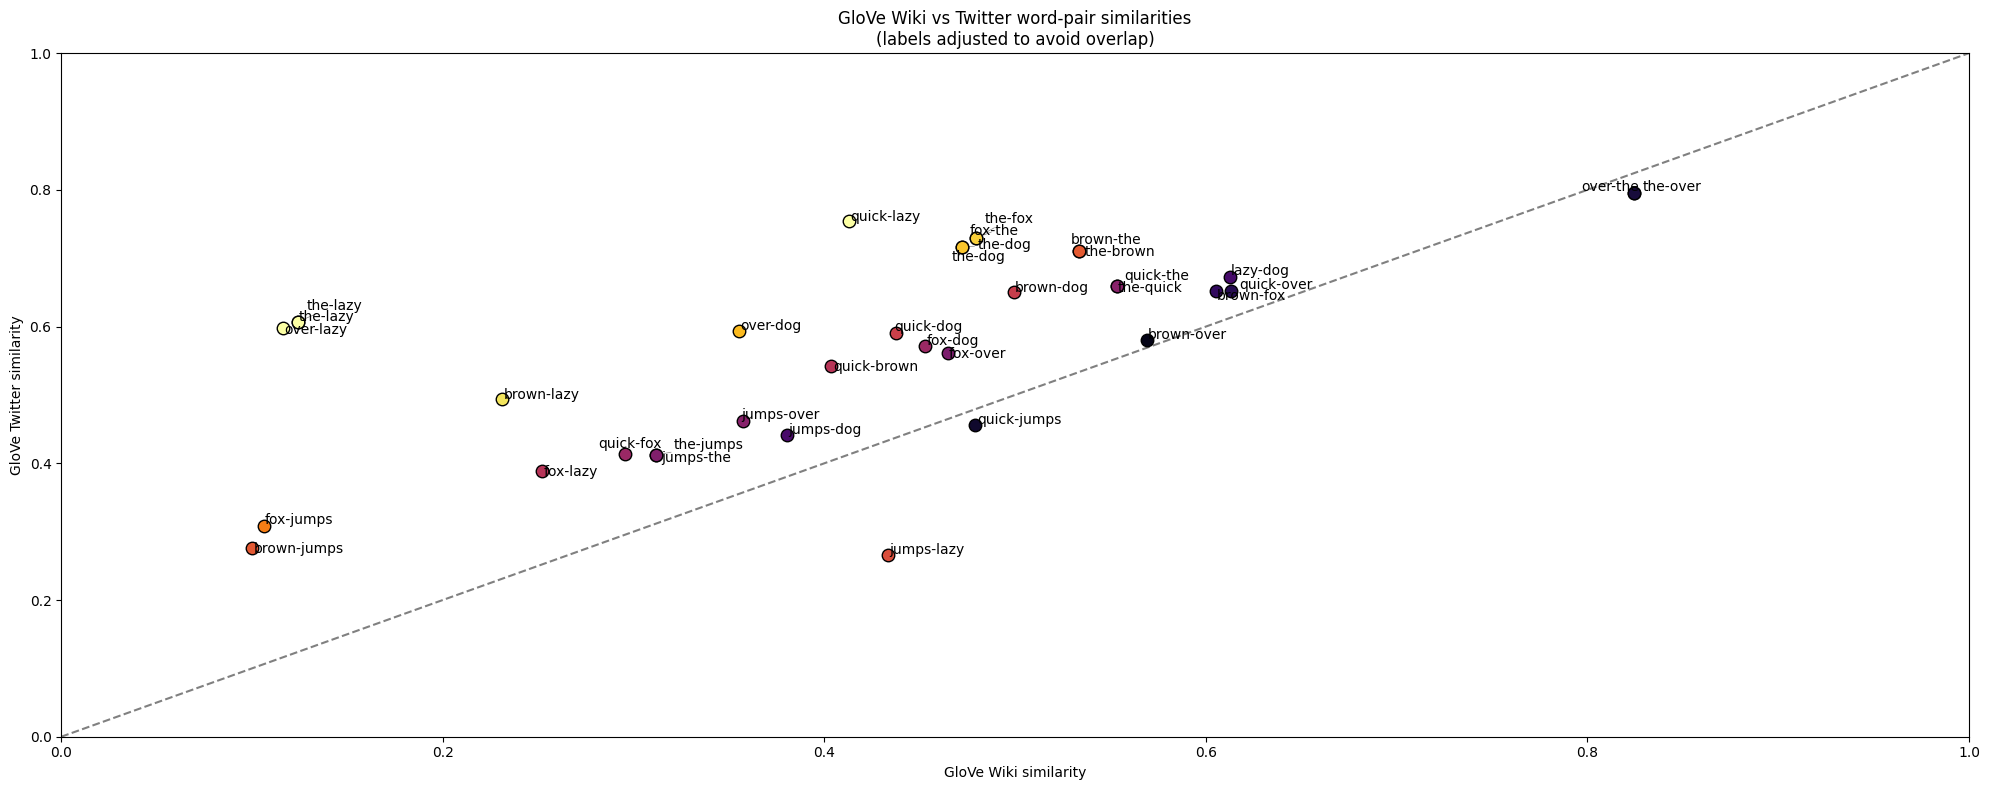

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text
import contextlib, io

text = 'The quick brown fox jumps over the lazy dog'
words = text.lower().split()

fig, ax = plt.subplots(figsize=(20,8))
# ax.set_facecolor('#000')  # light grey background

texts = []

for i in range(len(words)):
    for j in range(i+1, len(words)):
        w1, w2 = words[i], words[j]

        if w1 == w2:
            continue

        wiki_similarity = glove_wiki.similarity(w1, w2)
        twitter_similarity = glove_twitter.similarity(w1, w2)

        v = np.array([wiki_similarity, twitter_similarity])
        u = np.array([1., 1.])
        uu = np.dot(u, u)
        uv = np.dot(u, v)
        distance = np.linalg.norm(v - (uv / uu) * u)
        cval = distance * 5

        plt.plot(
            wiki_similarity,
            twitter_similarity,
            'o',
            markersize=9,
            markerfacecolor=mpl.cm.inferno(cval),
            markeredgecolor='k'
        )

        t = plt.text(
            wiki_similarity,
            twitter_similarity,
            f'{w1}-{w2}',
            fontsize=10,
            # color=mpl.cm.inferno(cval)
        )
        texts.append(t)

# silence adjust_text's debug prints
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    adjust_text(
        texts,
        only_move={'points': 'y', 'text': 'xy'},
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    )

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], '--', zorder=-30, color='gray')
plt.xlabel("GloVe Wiki similarity")
plt.ylabel("GloVe Twitter similarity")
plt.title("GloVe Wiki vs Twitter word-pair similarities\n(labels adjusted to avoid overlap)")
plt.tight_layout()
plt.show()


In [14]:
# Calculate the distance from unity line
v = np.array([wiki_similarity, twitter_similarity])
u = np.array([1, 1]) # Vector for unity line
uv = np.dot(u,v)**2


# distance = np.linalg.norm(v - (sum(np.dot(u,v)))/(np.linalg.norm(u)**2) * u)
